In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt


SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225])

%matplotlib inline

In [2]:
!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
!unzip a4_styles.zip && rm a4_styles.zip

--2020-08-23 16:42:52--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2170872 (2.1M) [application/zip]
Saving to: ‘a4_styles.zip’

a4_styles.zip       100%[===================>]   2.07M  5.90MB/s    in 0.4s    

2020-08-23 16:42:52 (5.90 MB/s) - ‘a4_styles.zip’ saved [2170872/2170872]

Archive:  a4_styles.zip
   creating: styles/
  inflating: styles/tubingen.jpg     
  inflating: styles/the_scream.jpg   
  inflating: styles/starry_night.jpg  
  inflating: styles/muse.jpg         
  inflating: styles/composition_vii.jpg  
  inflating: style-transfer-checks.npz  


In [3]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

answers = dict(np.load('style-transfer-checks.npz'))


In [4]:
#Loading pre-trained SqueezeNet model
cnn = torchvision.models.squeezenet1_1(pretrained=True).features

for param in cnn.parameters():
  param.requires_grad = False

def extract_features(x, cnn):
  features = []
  prev_feat = x

  for i, module in enumerate(cnn._modules.values()):
    next_feat = module(prev_feat)
    features.append(next_feat)
    prev_feat = next_feat
  return features

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


Content loss:
    $L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [5]:
#Computing content loss
def content_loss(content_weight, content_current, content_original):
  return torch.sum(content_weight * (content_current - content_original) ** 2)

##Style loss
Before computing content loss, we first need to compute gram matrix
Gram matrix is given by:
$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

In [6]:
def gram_matrix(features, normalize=True):
  N, C, H, W = features.size()
  features = features.reshape(N, C, -1)

  gram_matrix = torch.zeros([N,C,C]).to(features.device).to(features.dtype)
  for i in range(N):
    gram_matrix[i,:] = torch.mm(features[i,:], features[i,:].t())
    if(normalize):
      gram_matrix /= float(H*W*C)
    return gram_matrix

In [7]:
#Implementing style loss
def style_loss(feats, style_layers, style_targets, style_weights):
  loss = 0
  for i, layer in enumerate(style_layers):
    gram_feat = gram_matrix(feats[layer])
    loss += (style_weights[i] * torch.sum((gram_feat - style_targets[i])**2))
  return loss

In [8]:
#Total variation loss
def tv_loss(img, tv_weight):
  loss = 0
  loss += torch.sum((img[:,:,1:,:]-img[:,:,:-1,:])**2)
  loss += torch.sum((img[:,:,:,1:]-img[:,:,:,:-1])**2)
  loss *= tv_weight
  return loss

In [20]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone()

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(500):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

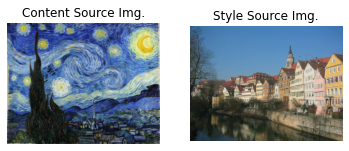

Iteration 0


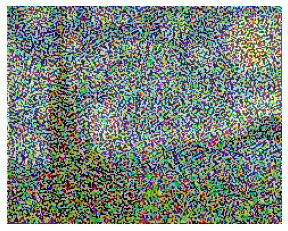

Iteration 100


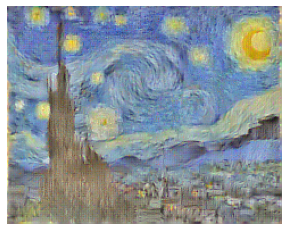

Iteration 200


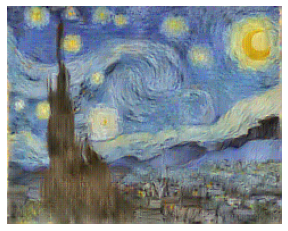

Iteration 300


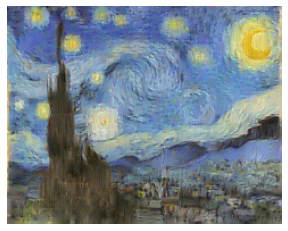

Iteration 400


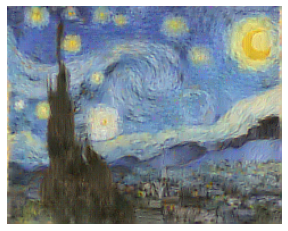

Iteration 499


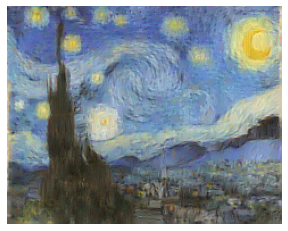

In [24]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/starry_night.jpg',
    'style_image' : 'styles/tubingen.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)